Loaded shape: (9544, 35)


,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,...,online_links,issue_dates,expiry_dates,job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score
0,NaN,Big data analytics working and database wareho...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],...,NaN,NaN,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a ...,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaborat...,NaN,0.850000
1,NaN,Fresher looking to join as a data analyst and ...,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],...,NaN,NaN,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in a...,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional ...,NaN,0.750000
2,NaN,NaN,"['Software Development', 'Machine Learning', '...","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],...,NaN,NaN,NaN,"Executive/ Senior Executive- Trade Marketing, ...",Master of Business Administration (MBA),At least 3 years,NaN,"Trade Marketing Executive\nBrand Visibility, S...",Brand Promotion\nCampaign Management\nField Su...,0.416667



Columns: ['address', 'career_objective', 'skills', 'educational_institution_name', 'degree_names', 'passing_years', 'educational_results', 'result_types', 'major_field_of_studies', 'professional_company_names', 'company_urls', 'start_dates', 'end_dates', 'related_skils_in_job', 'positions', 'locations', 'responsibilities', 'extra_curricular_activity_types', 'extra_curricular_organization_names', 'extra_curricular_organization_links', 'role_positions', 'languages', 'proficiency_levels', 'certification_providers', 'certification_skills', 'online_links', 'issue_dates', 'expiry_dates', 'job_position_name', 'educationaL_requirements', 'experiencere_requirement', 'age_requirement', 'responsibilities.1', 'skills_required', 'matched_score']

Missing values per column:
 address                                8760
career_objective                       4804
skills                                   56
educational_institution_name             84
degree_names                             84
passing

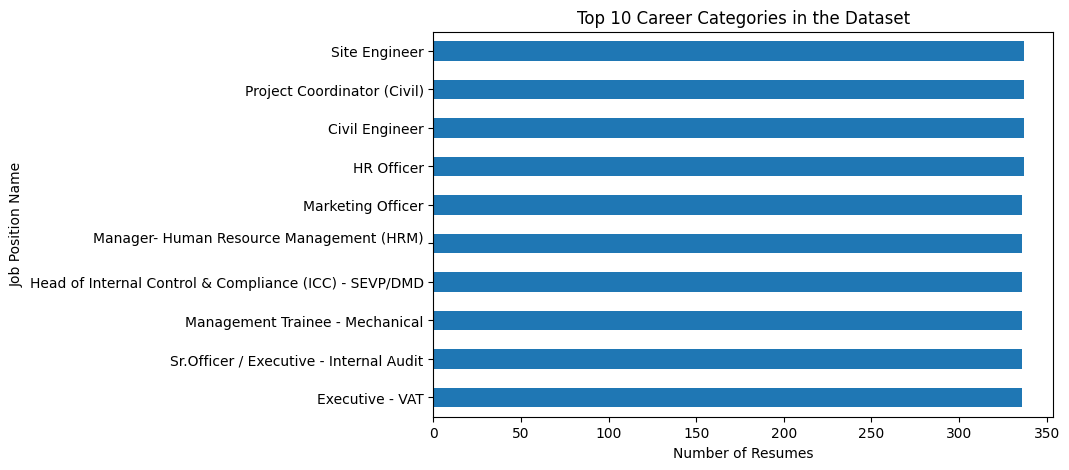

Saved cleaned data to: /kaggle/working/clean_resume_data.csv


In [12]:
import pandas as pd

# File path from the dataset we are using
path = "/kaggle/input/resume-data-for-ranking/resume_data_for_ranking.csv"

df = pd.read_csv(path)
print("Loaded shape:", df.shape)
display(df.head(3))
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum())


# Quick checks
print("Unique resume IDs:", df['resume_id'].nunique() if 'resume_id' in df.columns else "no resume_id column")
print("Unique job IDs:", df['job_id'].nunique() if 'job_id' in df.columns else "no job_id column")
if 'similarity_score' in df.columns:
    print("Similarity score stats:\n", df['similarity_score'].describe())

# Clean functionality, making it save and conservative
import re
import numpy as np

def clean_text(text):
    if pd.isna(text):
        return ""
    # ensure string
    text = str(text)
    # normalize whitespace and quotes
    text = text.replace("\r", " ").replace("\n", " ").replace("\t", " ")
    # remove weird unicode and control chars
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # lowercase
    text = text.lower()
    # keep basic punctuation + alphanumerics (feel free to relax)
    text = re.sub(r'[^a-z0-9\s\.,;:!?\(\)\-\/@#&%]', ' ', text)
    # collapse spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to the two main text columns (adjust names if different)
text_cols = []
for col in ['resume_text', 'job_description', 'resume', 'jobdesc', 'resume_content']:
    if col in df.columns:
        text_cols.append(col)

# If none of the common names matched, try to find likely text columns (fallback)
if not text_cols:
    # pick the two longest-text columns heuristically
    lengths = {c: df[c].astype(str).map(len).median() for c in df.columns}
    sorted_cols = sorted(lengths.items(), key=lambda x: x[1], reverse=True)
    text_cols = [sorted_cols[0][0]]
    if len(sorted_cols) > 1:
        text_cols.append(sorted_cols[1][0])
    print("No standard text column names found. Using fallback columns:", text_cols)

# Clean selected text columns
for c in text_cols:
    cleaned_name = c + "_clean"
    df[cleaned_name] = df[c].apply(clean_text)
    print(f"Created cleaned column: {cleaned_name}")

# Removes empty duplicate roles and saves the count
# Drop rows with empty cleaned resume or jobdesc (adjust names based on your text_cols)
resume_col = text_cols[0] + "_clean"
job_col = text_cols[1] + "_clean" if len(text_cols) > 1 else None

# Remove rows with both empty resume and empty jobdesc (be conservative)
if job_col:
    before = df.shape[0]
    df = df[~((df[resume_col] == "") | (df[job_col] == ""))]  # keep rows where both are non-empty
    after = df.shape[0]
    print(f"Rows kept after dropping empties (both fields needed): {after} (dropped {before-after})")
else:
    # If only one text column found, remove rows where that is empty
    before = df.shape[0]
    df = df[df[resume_col] != ""]
    after = df.shape[0]
    print(f"Rows kept after dropping empty resumes: {after} (dropped {before-after})")

# Drop exact duplicates on cleaned text columns
dup_subset = [resume_col] + ([job_col] if job_col else [])
before = df.shape[0]
df.drop_duplicates(subset=dup_subset, inplace=True)
after = df.shape[0]
print(f"Dropped duplicates: {before-after}")

# Reset index
df.reset_index(drop=True, inplace=True)

# Bar chart plot using mathlab to show the top carrer categories
import matplotlib.pyplot as plt

if 'job_position_name' in df.columns:
    top_jobs = df['job_position_name'].value_counts().head(10)
    plt.figure(figsize=(8,5))
    top_jobs.plot(kind='barh')
    plt.gca().invert_yaxis()  # so the top job is at the top
    plt.title("Top 10 Career Categories in the Dataset")
    plt.xlabel("Number of Resumes")
    plt.ylabel("Job Position Name")
    plt.show()

# Out file for the clean dataset
out_path = "/kaggle/working/clean_resume_data.csv"
# choose columns to keep for downstream: ids, cleaned texts, score (if exists)
keep = []
for candidate in ['resume_id', 'job_id', 'candidate_id', 'applicant_id']:
    if candidate in df.columns:
        keep.append(candidate)

keep += [resume_col]
if job_col:
    keep.append(job_col)
if 'similarity_score' in df.columns:
    keep.append('similarity_score')

# if keep is empty (no ids), just save cleaned columns and original columns
if not keep:
    keep = df.columns.tolist()  # fallback: save everything
else:
    # ensure uniqueness
    keep = list(dict.fromkeys(keep))

df[keep].to_csv(out_path, index=False)
print("Saved cleaned data to:", out_path)
